# Estimation of honey bee larval intakes per day


In [4]:
# goal: estimate the daily larval intakes of honey bee worker larvae and drone larvae if possible
# - baseline: growth rates of Bishop 1961 (exponential increase day 3-5, little increase day 1 and 6)
# - baseline: sugar/protein/moisture percentages from Brouwers and Beetsma 1987
import numpy as np
import pandas as pd
import scipy as sp

The following images show figures from Brouwers and Beetsma (1987) on the right and Bishop (1961) on the left. Bishop shows the quasi exponential growth of honey bee worker larvae over the first 3-4 days of their life. Other sources (Hrassnigg&Crailsheim 2005; Szolderits&Crailsheim1993) note that the qualitative form of growth does not differ for drones, but that the exponential phase is prolonged for roughly a day because drones get bigger and take a day longer to reach pupation.

Brouwers & Beetsma show moisture and macronutrient content for drone, worker and queen larvae over the course of their development. This data will be used to try and fit daily nutrient needs for larvae further below using default BEEHAVE intake values if possible.

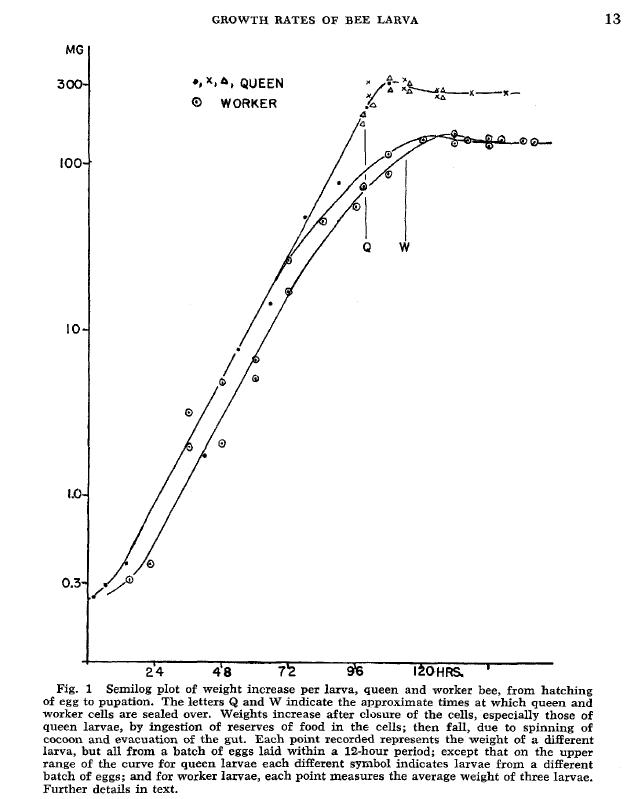
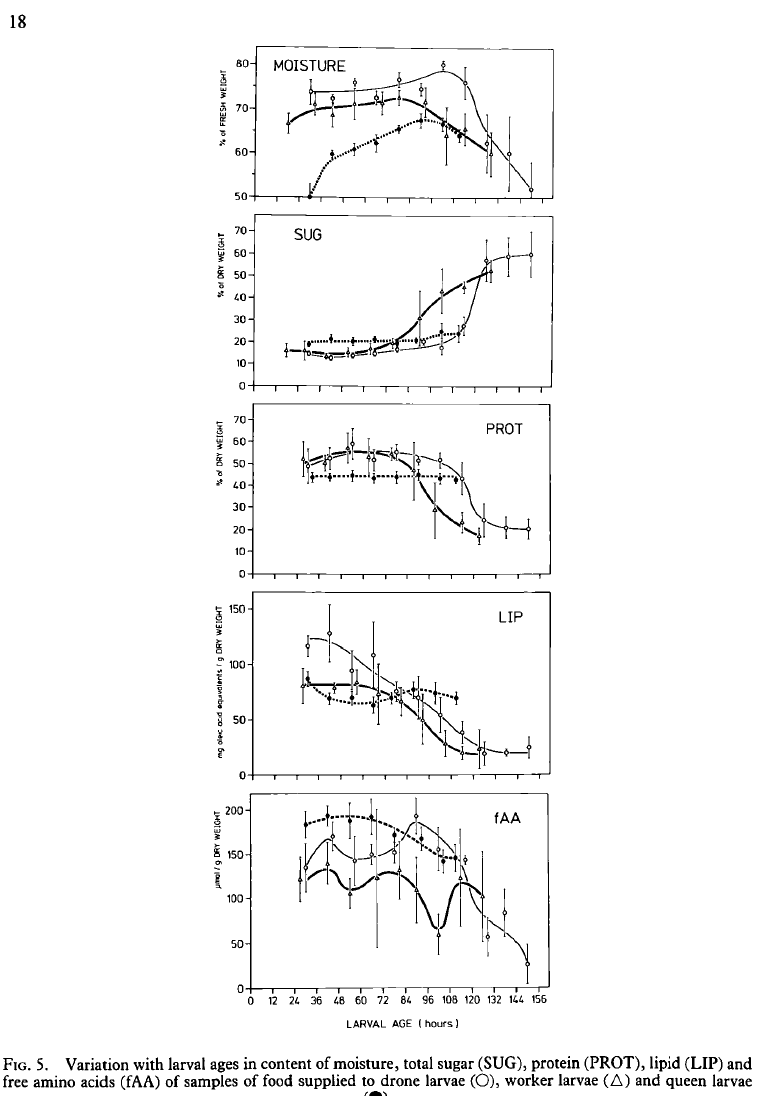

## Worker larva estimate

In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


sugartohoney = 1.272 # BEEHAVE
nectartohoney = 0.4 # BEEHAVE
pollentoprotein = 0.2 # BEEHAVE 


# dry mass (Brouwers&Beetsma):
water_content = np.array([0.65, 0.7, 0.7, 0.7, 0.65, 0.6])
dry_matter_frac = 1 - water_content

# Contents on DM (Brouwers&Beetsma), just estimates: 
sugar_content_DM = np.array([0.18, 0.15, 0.18, 0.3, 0.5, 0.55]) # rough estimates based on the publication; adjusted a little within range of reasonable uncertainty
protein_content_DM = np.array([0.5, 0.50, 0.55, 0.4, 0.2, 0.15]) # rough estimates based on the publication; adjusted a little within range of reasonable uncertainty

# Desired totals
goal_sugar = 59.4
goal_protein = 20

# Smoothed growth shape: more gradual, approx. lognormal/exponential rise and fall, 
base = np.array([4**0, 4**1, 4**2, 4**3, 25, 10])
profile = base / base.sum()

# Quadratic objective: sum (x_i/profile_i - k)**2, 
def objective(x):
    ratio = x / (profile * x.sum())
    return np.sum((ratio - 1)**2)

# Constraints: total sugar and protein match goals exactly
cons = [
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, sugar_content_DM) - goal_sugar},
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, protein_content_DM) - goal_protein}
]

# Bounds to ensure non-negativity 
bounds = [(1, None), (4, None), (16, None), (64, None), (20, None), (5, None)]

# Initial guess (scaled to total fresh mass 150mg)
x0 = 150 * profile

# Solve
result = minimize(objective, x0, constraints=cons, bounds=bounds, method='SLSQP')
x_out = result.x

# daily estimates
dry = x_out * dry_matter_frac
sugar = dry * sugar_content_DM
protein = dry * protein_content_DM

tab = pd.DataFrame({
    'day': np.arange(1,7),
    'intake fresh food (mg)': np.round(x_out,2),
    'intake dry food (mg)': np.round(dry,2),
    'sugar (mg)': np.round(sugar,2),
    'rel. sugar budget (%)': np.round(sugar/goal_sugar*100, 2),
    'protein (mg)': np.round(protein,2),
    'rel. protein budget (%)': np.round(protein/goal_protein*100, 2),
    'rel. fresh mass gain (%)': np.round(x_out/x_out.sum()*100,2),
})
#tab.to_csv('worker_larva_macro_final_opt.csv', index=False)
print(sugar.sum(), protein.sum(), x_out.sum())
tab


29.728388111715454 17.77537857592316 193.00630959871137


,day,intake fresh food (mg),intake dry food (mg),sugar (mg),rel. sugar budget (%),protein (mg),rel. protein budget (%),rel. fresh mass gain (%)
0,1,1.00,0.35,0.06,0.11,0.18,0.88,0.52
1,2,4.00,1.20,0.18,0.30,0.60,3.00,2.07
2,3,16.00,4.80,0.86,1.45,2.64,13.20,8.29
3,4,64.00,19.20,5.76,9.70,7.68,38.40,33.16
4,5,20.00,7.00,3.50,5.89,1.40,7.00,10.36
5,6,88.01,35.20,19.36,32.59,5.28,26.40,45.60


Sadly these values from Brouwers&Beetsma work neither for worker larvae nor for drone larvae very well. For drone larvae there is also Matsuka et al. (1973) available which very nicely fits to estimates of total sugar and protein necessary to rear one drone larva from scientific literatute (mostly Hrassnigg&Crailsheim). 

For worker larvae I will just have to assume a quasi exponential growth to day 4-5 with a sharp decrease in intake on day 6 and a relatively increased protein need in the beginning with an increase in sugar intake towards the end of development. This is safe to assume from all the literature available and will be used a broad estimate that is at the very least far more precise than the previous assumption of the same intake every day. Therefore it is reasonable to assume that the data of Brouwers&Beetsma is still valid.

It is highly likely that the estimate for total sugar needed is strongly overestimated as not all of this sugar actually gets taken in by the larvae. This sugar estimate is much more of a budget that is necessary from a colony perspective to rear one worker larva to pupation. We can thus assume that quite a lot of this sugar is actually metabolized by nurses for their own uptake or used as energy necessary to produce brood jellies and does not end up as a nutrient component within the jelly. Below I halved the sugar necessary to reach relative needs of the larvae over their 6 days of development that agree very much with the baseline assumptions of scientific literature and the recorded data of Brouwers&Beetsma. As the authors did not quantify the total amounts of brood food they found in the cells this is as close as it gets as long as I use the sources provided here.

This is most likely not 100% accurate. The relative distribution of nutrient intake over the 6 days should still be biologically accurate - at the very least far more accurate than assuming that the larvae take in the same fraction of nutrients every day until pupation.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# dry mass (Brouwers&Beetsma):
water_content = np.array([0.65, 0.7, 0.7, 0.7, 0.65, 0.6])
dry_matter_frac = 1 - water_content

# Contents on DM (Brouwers&Beetsma), just rough estimates: 
sugar_content_DM = np.array([0.18, 0.15, 0.18, 0.3, 0.5, 0.55]) # rough estimates based on the publication
protein_content_DM = np.array([0.5, 0.50, 0.55, 0.4, 0.2, 0.15]) # rough estimates based on the publication

# Desired totals
goal_sugar = 30
goal_protein = 20

# Smoothed growth shape: approx. exponential, roughly taken from Bishop's growth rate
base = np.array([4**0, 4**1, 4**2, 4**3, 25, 10])
growth_profile = base / base.sum()

# Quadratic objective: sum (x_i/profile_i - k)**2, 
def func(x):
    ratio = x / (growth_profile * x.sum())
    return np.sum((ratio - 1)**2)

# Constraints: total sugar and protein match goals exactly
cons = [
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, sugar_content_DM) - goal_sugar},
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, protein_content_DM) - goal_protein}
]

# Bounds to ensure non-negativity 
bounds = [(1, None), (4, None), (16, None), (64, None), (20, None), (5, None)]

# Initial guess (scaled to total fresh mass 150mg --> 144–162 (Hrassnigg&Crailsheim 2005))
x0 = 150 * growth_profile

# Solve
result = minimize(func, x0, constraints=cons, bounds=bounds, method='SLSQP')
x_out = result.x

# daily estimates
dry = x_out * dry_matter_frac
sugar = dry * sugar_content_DM
protein = dry * protein_content_DM

tab = pd.DataFrame({
    'day': np.arange(1,7),
    'intake fresh food (mg)': np.round(x_out,2),
    'intake dry food (mg)': np.round(dry,2),
    'sugar (mg)': np.round(sugar,2),
    'rel. sugar budget (%)': np.round(sugar/goal_sugar*100, 2),
    'protein (mg)': np.round(protein,2),
    'rel. protein budget (%)': np.round(protein/goal_protein*100, 2),
    'rel. fresh mass gain (%)': np.round(x_out/x_out.sum()*100,2),
})
#tab.to_csv('worker_larva_macro_final_opt.csv', index=False)
print(sugar.sum(), protein.sum(), x_out.sum())
tab



29.999999990603612 19.999999979061673 212.20418093716432


,day,intake fresh food (mg),intake dry food (mg),sugar (mg),rel. sugar budget (%),protein (mg),rel. protein budget (%),rel. fresh mass gain (%)
0,1,1.69,0.59,0.11,0.36,0.30,1.48,0.80
1,2,6.06,1.82,0.27,0.91,0.91,4.54,2.85
2,3,16.00,4.80,0.86,2.88,2.64,13.20,7.54
3,4,65.09,19.53,5.86,19.53,7.81,39.05,30.67
4,5,94.25,32.99,16.49,54.98,6.60,32.99,44.42
5,6,29.11,11.64,6.40,21.35,1.75,8.73,13.72


## Drone larva estimate

The following tables are taken from Matsuka et al. 1973. In table 1 they noted moisture, dry matter content and the nutrient distribution of this dry matter for every age of drone larvae from day 1 - day 6. For the day 0 I assumed that the larvae only get royal jelly, which has been analyzed for this study as well and is well defendable based on other studies.

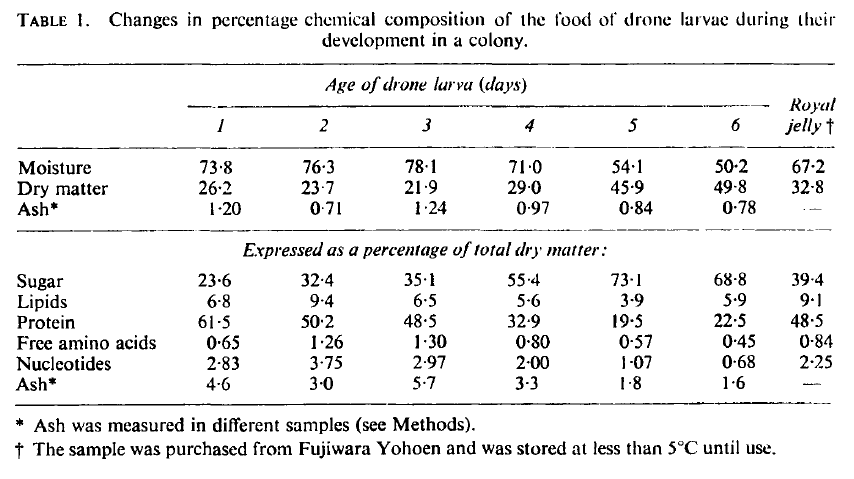
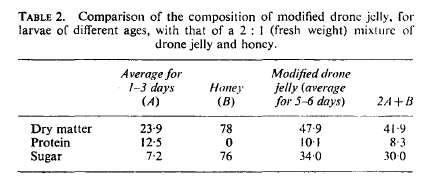

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize


sugartohoney = 1.272 # BEEHAVE
nectartohoney = 0.4 # BEEHAVE
pollentoprotein = 0.2 # BEEHAVE 


# dry mass (Matsuka):
water_content = np.array([0.7, 0.738, 0.763, 0.781, 0.71, 0.541, 0.502])
dry_matter_frac = 1 - water_content

# Contents on DM (Matsuka), just estimates: 
sugar_content_DM = np.array([0.394, 0.236, 0.324, 0.351, 0.554, 0.731, 0.688]) # Matsuka et al. 1973
protein_content_DM = np.array([0.485, 0.61, 0.5, 0.485, 0.329, 0.195, 0.225]) # play around here to find a proper fit that seems somewhat biologically reasonable

# Desired totals
goal_sugar = 100
goal_protein = 50

# Smoothed growth shape: more gradual, approx. lognormal/exponential rise and fall, 
base = np.array([4**0, 4**1, 4**2, 4**3, 100, 50, 10]) # simply assumed quasi exponential growth, supported by Hrassnigg&Crailsheim 2005; 4 as the base for exponential growth was chosen on a whim and is just supposed to give a minimum baseline to improve the fit from 
profile = base / base.sum()

# Quadratic objective: sum (x_i/profile_i - k)^2, 
def objective(x):
    ratio = x / (profile * x.sum())
    return np.sum((ratio - 1)**2)

# Constraints: total sugar and protein match goals exactly
cons = [
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, sugar_content_DM) - goal_sugar},
    {'type': 'eq', 'fun': lambda x: np.dot(x*dry_matter_frac, protein_content_DM) - goal_protein}
]

# Non-negativity and minimum
bounds = [(1, None), (4, None), (16, None), (64, None), (64, None), (16, None), (5, None)]

# Initial guess (scaled to total fresh mass 300mg --> 262–419 (Hrassnigg&Crailsheim 2005))
x0 = 300 * profile

# Solve
result = minimize(objective, x0, constraints=cons, bounds=bounds, method='SLSQP')
x_out = result.x

# daily estimates
dry = x_out * dry_matter_frac
sugar = dry * sugar_content_DM
protein = dry * protein_content_DM

tab = pd.DataFrame({
    'day': np.arange(1,8),
    'intake fresh food (mg)': np.round(x_out,2),
    'intake dry food (mg)': np.round(dry,2),
    'sugar (mg)': np.round(sugar,2),
    'rel. sugar budget (%)': np.round(sugar/goal_sugar*100, 2),
    'protein (mg)': np.round(protein,2),
    'rel. protein budget (%)': np.round(protein/goal_protein*100, 2),
    'rel. fresh mass gain (%)': np.round(x_out/x_out.sum()*100,2),
})
#tab.to_csv('worker_larva_macro_final_opt.csv', index=False)
print(sugar.sum(), protein.sum(), x_out.sum())
tab


99.99999994384359 49.999999997003435 505.4251658043905


,day,intake fresh food (mg),intake dry food (mg),sugar (mg),rel. sugar budget (%),protein (mg),rel. protein budget (%),rel. fresh mass gain (%)
0,1,2.05,0.61,0.24,0.24,0.30,0.60,0.41
1,2,7.90,2.07,0.49,0.49,1.26,2.53,1.56
2,3,29.82,7.07,2.29,2.29,3.53,7.07,5.90
3,4,90.71,19.87,6.97,6.97,9.64,19.27,17.95
4,5,205.59,59.62,33.03,33.03,19.62,39.23,40.68
5,6,147.31,67.61,49.43,49.43,13.18,26.37,29.14
6,7,22.04,10.97,7.55,7.55,2.47,4.94,4.36
